# Capstone Project - The Battle of the Neighborhoods (Week 2)


## Table of contents
* [Introduction](#introduction)
* [Business Problem](#business_problem)
* [Methodology](#methodology)
* [Data](#data)
* [Analysis](#analysis)
* [Results](#results)
* [Discussion](#conclusion)
* [Conclusion](#conclusion)


## Introduction <a name="introduction"></a>

According to Wikipedia, the city of Atlanta has recently become relatively more diverse in the recent years. This is due to a large population of migrants from other parts of the U.S., in addition to many recent immigrants to the U.S. who have made the metropolitan area their home, establishing Atlanta as the cultural and economic hub of an increasingly multi-cultural metropolitan area. This has resulted in the establishment of some extremely successful authentic ethnic restaurants in the city, ranging from Vietnamese, Indian, Cuban, Korean, Mexican, and Chinese, to Ethiopian. This project is about identifying areas that may be under-served as far as good Indian restaurants are concerned and make recommendations of a neighborhood to any prospective entrepreneurs thay may be looking to decide on a neighborhood to open a new restaurant

## Business Problem <a name="business_problem"></a>

For a prospective business entrepreneur, that would like to open a new restaurant in the Atlanta metro area and make it profitable, one of the biggest question would be to decide on a location to establish their new venture. This project will use a variety of Business Analysis and machine learning techiques to make recommendations to address the question: 'What is the best location in the Atlanta metro area to open a new Indian restaurant'. Although this initial implementation is targetted towards stakeholders trying to open a new Indian restaurant, this methodology could be expanded to potentially make recommendations on any kind of restaurants, including fast food restaurant chains, resulting in a wide range of stake holders

## Methodology <a name="methodology"></a>

In this project we will be identifying the neighborhood that would benefit the most from a new Indian restaurant.

As part of the analysis, we make the following assumptions
* Restaurants do well in a commercial neighborhood with a lot of retail establishments and other established restaurants
* Neighborhood data is used to create clusters (using **k-means clustering**) to identify commercial neighborhoods
* For each neighborhood that are in the commercial cluster, a detailed analysis is performed on the ratio of Indian restaurants that are within 1000 meters from the center of the neighborhood
* Recommendations are made based on the neighborhood that has the least concentration of Indian restaurants compared to other type of cuisines



## Data <a name="data"></a>

This implementation will leverage the following data from various sources:

1. Neighborhoods in Atlanta Wikipedia https://en.wikipedia.org/wiki/Neighborhoods_in_Atlanta
2. Geocoding - Nominatim API to determine the latitude/longitude for each of these neighborhoods https://wiki.openstreetmap.org/wiki/Nominatim
3. Location Data - Foursquare API will be leveraged to get the list of most popular venues for each of these neighborhoods


### Atlanta Neighborhood Data

Atlanta Wikipedia https://en.wikipedia.org/wiki/Neighborhoods_in_Atlanta contains several useful information about the differnt neighborhoods in Atlanta. This implementation would extract the data from this URL using BeautifulSoup and pick the different neighborhoods in the Atlanta Midtown area.

#### Import all the necessary packages

In [1]:
#!conda install -c conda-forge folium --yes 

In [2]:
from bs4 import BeautifulSoup
import requests
import urllib.request
import numpy as np
import pandas as pd
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import folium

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

#### Extract data from Wikipedia using BeautifulSoup

In [3]:
fp = urllib.request.urlopen("https://en.wikipedia.org/wiki/Neighborhoods_in_Atlanta")
mybytes = fp.read()

mystr = mybytes.decode("utf8")
fp.close()

In [4]:
soup = BeautifulSoup(mystr,'lxml')
#soup

In [ ]:
neighborhoods=[]

for i in range(1,10):
    neighborhoods.append(soup.find("table",{"class":"multicol"}).find_all("li")[i].find("a").contents[0])
for i in range(3,9):
    neighborhoods.append((soup.find("table",{"class":"multicol"}).find_all("li"))[10].find_all("ul")[0].find_all("li")[i].find("a").contents[0])

for i in range(0,5):
    neighborhoods.append((soup.find("table",{"class":"multicol"}).find_all("li"))[20].find_all("ul")[0].find_all("li")[i].find("a").contents[0])
for i in range(26,49):
    neighborhoods.append((soup.find("table",{"class":"multicol"}).find_all("li"))[i].find("a").contents[0])



#### Initialize Credentials

In [6]:
# The code was removed by Watson Studio for sharing.

In [7]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
VERSION = '20180605' # Foursquare API version

### Get the geographical coordinates for these Atlanta Neighborhoods

In [ ]:
import time

location_info = []

for aNeighborhood in neighborhoods:
    address = aNeighborhood + ', GA'
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    if (location != None):
        latitude = location.latitude
        longitude = location.longitude
        location_info.append([aNeighborhood, latitude, longitude])
    time.sleep(1)


In [9]:
neighborhoods = pd.read_csv('AtlantaGeocodes.csv', header=None)

neighborhoods.reset_index(inplace=True)

neighborhoods.drop(['index'], axis=1,inplace=True)

print(neighborhoods.shape)

print (neighborhoods.index)
neighborhoods.columns
print (neighborhoods.tail())

(114, 3)
RangeIndex(start=0, stop=114, step=1)
                 0          1          2
109        Roswell  34.023320 -84.360022
110       Dunwoody  33.948365 -84.334963
111    Johns Creek  34.018156 -84.190196
112        Suwanee  34.051490 -84.071300
113  Lawrenceville  33.956215 -83.987962


In [10]:
neighborhoods.columns=["Neighborhood", "Latitude", "Longitude"]
neighborhoods

,Neighborhood,Latitude,Longitude
0,Castleberry Hill,33.749587,-84.400056
1,Fairlie-Poplar,33.756495,-84.391038
2,Five Points,33.754444,-84.389814
3,Peachtree Center,33.760344,-84.386809
4,South Downtown,33.750975,-84.393046
...,...,...,...
109,Roswell,34.023320,-84.360022
110,Dunwoody,33.948365,-84.334963
111,Johns Creek,34.018156,-84.190196
112,Suwanee,34.051490,-84.071300


### This completes the collection of the geo coordinates for the neighborhoods in Atlanta. Plot them in a map

Get the coordinates of Atlanta to center the map

In [11]:
address = 'Atlanta, GA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(address, latitude, longitude))

The geograpical coordinate of Atlanta, GA are 33.7490987, -84.3901849.


In [12]:
import folium

# create map of Toronto using latitude and longitude values
map_atlanta = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng,  neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Neighborhood']):
    label = neighborhood
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_atlanta)  
    
map_atlanta

### Collect the data about the top venues for each of these neighborhoods thru' API calls to Foursquare

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        #print (url)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:

atlanta_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )


In [17]:
atlanta_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Castleberry Hill,33.749587,-84.400056,Wine Shoe,33.751559,-84.398937,Wine Shop
1,Castleberry Hill,33.749587,-84.400056,Bottle Rocket,33.750109,-84.400979,Sushi Restaurant
2,Castleberry Hill,33.749587,-84.400056,No Mas! Cantina,33.749785,-84.400847,Mexican Restaurant
3,Castleberry Hill,33.749587,-84.400056,Castleberry Hill,33.748233,-84.401736,Neighborhood
4,Castleberry Hill,33.749587,-84.400056,Nelson Street Gallery,33.751228,-84.399390,Art Gallery


In [49]:
atlanta_venues[atlanta_venues['Neighborhood']=='Duluth']

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
4057,Duluth,34.002857,-84.144105,Eddie Owen Presents at Red Clay Theatre,34.002489,-84.145004,Theater
4058,Duluth,34.002857,-84.144105,Simply Done Donuts,34.003749,-84.144777,Donut Shop
4059,Duluth,34.002857,-84.144105,Pure Taqueria,34.002817,-84.144618,Mexican Restaurant
4060,Duluth,34.002857,-84.144105,Noona,34.003587,-84.144932,Steakhouse
4061,Duluth,34.002857,-84.144105,Crave Pie Studio,34.002795,-84.144776,Bakery
4062,Duluth,34.002857,-84.144105,"Peace, Love & Decorating",34.002749,-84.145332,Furniture / Home Store
4063,Duluth,34.002857,-84.144105,O4W Pizza,34.002802,-84.145074,Pizza Place
4064,Duluth,34.002857,-84.144105,Maple Street Biscuit Company,34.003659,-84.144991,Breakfast Spot
4065,Duluth,34.002857,-84.144105,Good Word Brewing & Public House,34.003220,-84.144343,Brewery
4066,Duluth,34.002857,-84.144105,Dreamland BBQ Duluth,34.003542,-84.144400,BBQ Joint


This completes the data collection for all the data needed for this implementation

### Data Preprocessing

Encode the categories data to numeric values to be used by the model

In [18]:
# one hot encoding
atlanta_onehot = pd.get_dummies(atlanta_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
atlanta_onehot['Neighborhood'] = atlanta_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [atlanta_onehot.columns[-1]] + list(atlanta_onehot.columns[:-1])
atlanta_onehot = atlanta_onehot[fixed_columns]

atlanta_onehot.head()
atlanta_onehot.to_csv('c:\\IBMDataScience\\Capstone\\AtlantaVenues_onehot.csv')

Filter the dataframe by the relevant restaurant categories

In [19]:

restaurant_types = ['Restaurant', 'Breakfast', 'Buffet', 'Burger Joint', 'Burrito Place', 'Cafetaria', 'Cafe', 'Food', 'Noodle', 'Pizza', 'Sandwich', 'Steakhouse', 'Taco']
restaurant_cols = []
for i in range(0,len(restaurant_types)):
    relevant_cols = [col for col in atlanta_onehot.columns if restaurant_types[i] in col]
    restaurant_cols = restaurant_cols + relevant_cols
    
print (restaurant_cols)
atlanta_onehot_restaurants = atlanta_onehot[restaurant_cols]
atlanta_onehot_restaurants.head()

['American Restaurant', 'Arepa Restaurant', 'Asian Restaurant', 'Brazilian Restaurant', 'Cajun / Creole Restaurant', 'Caribbean Restaurant', 'Chinese Restaurant', 'Comfort Food Restaurant', 'Cuban Restaurant', 'Dim Sum Restaurant', 'Eastern European Restaurant', 'English Restaurant', 'Ethiopian Restaurant', 'Falafel Restaurant', 'Fast Food Restaurant', 'Filipino Restaurant', 'French Restaurant', 'Gluten-free Restaurant', 'Greek Restaurant', 'Halal Restaurant', 'Indian Chinese Restaurant', 'Indian Restaurant', 'Italian Restaurant', 'Japanese Restaurant', 'Korean Restaurant', 'Latin American Restaurant', 'Malay Restaurant', 'Mediterranean Restaurant', 'Mexican Restaurant', 'Middle Eastern Restaurant', 'Modern European Restaurant', 'Moroccan Restaurant', 'New American Restaurant', 'North Indian Restaurant', 'Restaurant', 'Scandinavian Restaurant', 'Seafood Restaurant', 'Southern / Soul Food Restaurant', 'Spanish Restaurant', 'Sushi Restaurant', 'Szechuan Restaurant', 'Tapas Restaurant', '

,American Restaurant,Arepa Restaurant,Asian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Cuban Restaurant,Dim Sum Restaurant,...,Food Court,Food Service,Food Truck,Health Food Store,Southern / Soul Food Restaurant,Noodle House,Pizza Place,Sandwich Place,Steakhouse,Taco Place
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Group them by Neighborhood

In [20]:
atlanta_grouped = atlanta_onehot.groupby('Neighborhood').mean().reset_index()
atlanta_grouped

,Neighborhood,Zoo Exhibit,ATM,Accessories Store,Adult Boutique,Adult Education Center,Airport,American Restaurant,Antique Shop,Aquarium,...,Vietnamese Restaurant,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Adams Park,0.0,0.0,0.0,0.0,0.0,0.0,0.050000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.050000,0.050000,0.000000,0.0
1,Adamsville,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,Alpharetta,0.0,0.0,0.0,0.0,0.0,0.0,0.059701,0.0,0.0,...,0.014925,0.0,0.0,0.000000,0.000000,0.014925,0.000000,0.029851,0.000000,0.0
3,Amal Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,Atkins Park,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.027027,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,Washington Park,0.0,0.0,0.0,0.0,0.0,0.0,0.035714,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.107143,0.000000,0.000000,0.0
108,West End,0.0,0.0,0.0,0.0,0.0,0.0,0.019231,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
109,West Lake,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.055556,0.000000,0.000000,0.0
110,West Manor,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


Get the top 10 venues for each of these neighborhood

In [21]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [22]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = atlanta_grouped['Neighborhood']

for ind in np.arange(atlanta_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(atlanta_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adams Park,Convenience Store,Sandwich Place,Gas Station,Grocery Store,Pizza Place,Food,Smoke Shop,Shopping Mall,Fried Chicken Joint,Discount Store
1,Adamsville,Discount Store,Fried Chicken Joint,Seafood Restaurant,Gym / Fitness Center,Gas Station,Chinese Restaurant,Liquor Store,Roller Rink,Laundromat,Food
2,Alpharetta,Clothing Store,New American Restaurant,American Restaurant,Furniture / Home Store,Women's Store,Hotel,Kids Store,Coffee Shop,Burger Joint,Residential Building (Apartment / Condo)
3,Amal Heights,Park,Southern / Soul Food Restaurant,Non-Profit,Trail,Bar,Music Venue,Chinese Restaurant,Home Service,Falafel Restaurant,Farm
4,Atkins Park,Pizza Place,Pub,Bakery,Bar,Mexican Restaurant,Garden Center,Park,Italian Restaurant,Liquor Store,Bank


In [23]:
neighborhoods_venues_sorted[neighborhoods_venues_sorted['Neighborhood'] == 'Alpharetta']

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Alpharetta,Clothing Store,New American Restaurant,American Restaurant,Furniture / Home Store,Women's Store,Hotel,Kids Store,Coffee Shop,Burger Joint,Residential Building (Apartment / Condo)


### K Means clustering 

In [24]:
# set number of clusters
kclusters = 4

atlanta_grouped_clustering = atlanta_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(atlanta_grouped_clustering)

# check cluster labels generated for each row in the dataframe
print (kmeans.labels_[0:10])
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

[3 0 0 0 0 0 3 0 0 0]


add clustering labels to the dataframe


In [25]:
atlanta_merged = neighborhoods

atlanta_merged = atlanta_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood', how='right')
print (atlanta_merged['Cluster Labels'])
atlanta_merged.head()

0      0
1      0
2      0
3      0
4      0
      ..
109    0
110    0
111    0
112    0
113    0
Name: Cluster Labels, Length: 114, dtype: int32


,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Castleberry Hill,33.749587,-84.400056,0,Art Gallery,Lounge,BBQ Joint,Park,Gas Station,Sports Club,Fast Food Restaurant,Southern / Soul Food Restaurant,Restaurant,Caribbean Restaurant
1,Fairlie-Poplar,33.756495,-84.391038,0,Sandwich Place,Hotel,Aquarium,Coffee Shop,Museum,Mediterranean Restaurant,American Restaurant,Hotel Bar,Fast Food Restaurant,Southern / Soul Food Restaurant
2,Five Points,33.754444,-84.389814,0,Sandwich Place,Hotel,Seafood Restaurant,Hotel Bar,American Restaurant,Juice Bar,Mediterranean Restaurant,Burger Joint,Caribbean Restaurant,Music Venue
3,Peachtree Center,33.760344,-84.386809,0,Hotel,Sandwich Place,American Restaurant,Hotel Bar,Coffee Shop,Aquarium,Pizza Place,Museum,Mediterranean Restaurant,Lounge
4,South Downtown,33.750975,-84.393046,0,Sandwich Place,Lounge,Art Gallery,American Restaurant,Café,Park,Coffee Shop,Mexican Restaurant,Hotel,Breakfast Spot


In [26]:
neighborhoods_venues_sorted.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,3,Adams Park,Convenience Store,Sandwich Place,Gas Station,Grocery Store,Pizza Place,Food,Smoke Shop,Shopping Mall,Fried Chicken Joint,Discount Store
1,0,Adamsville,Discount Store,Fried Chicken Joint,Seafood Restaurant,Gym / Fitness Center,Gas Station,Chinese Restaurant,Liquor Store,Roller Rink,Laundromat,Food
2,0,Alpharetta,Clothing Store,New American Restaurant,American Restaurant,Furniture / Home Store,Women's Store,Hotel,Kids Store,Coffee Shop,Burger Joint,Residential Building (Apartment / Condo)
3,0,Amal Heights,Park,Southern / Soul Food Restaurant,Non-Profit,Trail,Bar,Music Venue,Chinese Restaurant,Home Service,Falafel Restaurant,Farm
4,0,Atkins Park,Pizza Place,Pub,Bakery,Bar,Mexican Restaurant,Garden Center,Park,Italian Restaurant,Liquor Store,Bank


Show the different clusters in a map of Atlanta

In [27]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


#rainbow = ['#8000ff', '#2adddd', '#d4dd80', '#ff0000']  - original

rainbow = ['#8000ff', '#40ff80', '#0008ff', '#ff0000']


# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(atlanta_merged['Latitude'], atlanta_merged['Longitude'], atlanta_merged['Neighborhood'], atlanta_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=2,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Analysis <a name="analysis"></a>

Take a closer look at each of the clusters to determine which one(s) could be considered as commercial neighborhoods

In [28]:
cluster0_df = atlanta_merged.loc[atlanta_merged['Cluster Labels'] == 0, atlanta_merged.columns[[0] + list(range(4, atlanta_merged.shape[1]))]]

cluster0_df['1st Most Common Venue'].value_counts()
#cluster1_df.head()

Pizza Place                9
Clothing Store             6
Italian Restaurant         4
Park                       4
Sandwich Place             4
Cosmetics Shop             4
Trail                      3
Business Service           3
Discount Store             3
Bar                        3
Hotel                      3
Baseball Field             3
Pharmacy                   3
Home Service               2
Mexican Restaurant         2
Fast Food Restaurant       2
Restaurant                 2
New American Restaurant    2
Art Gallery                2
Thrift / Vintage Store     2
Coffee Shop                2
Wings Joint                2
Spa                        1
Yoga Studio                1
Pool Hall                  1
Other Repair Shop          1
Korean Restaurant          1
Zoo Exhibit                1
Steakhouse                 1
American Restaurant        1
Food & Drink Shop          1
Rental Car Location        1
Pet Store                  1
Gas Station                1
Fishing Store 

In [29]:
cluster1_df = atlanta_merged.loc[atlanta_merged['Cluster Labels'] == 1, atlanta_merged.columns[[0] + list(range(4, atlanta_merged.shape[1]))]]

cluster1_df['1st Most Common Venue'].value_counts()
#cluster1_df.head()

Gas Station    1
Name: 1st Most Common Venue, dtype: int64

In [30]:
cluster2_df = atlanta_merged.loc[atlanta_merged['Cluster Labels'] == 2, atlanta_merged.columns[[0] + list(range(4, atlanta_merged.shape[1]))]]

cluster2_df['1st Most Common Venue'].value_counts()

Health Food Store    1
Name: 1st Most Common Venue, dtype: int64

In [31]:
cluster3_df = atlanta_merged.loc[atlanta_merged['Cluster Labels'] == 3, atlanta_merged.columns[[0] + list(range(4, atlanta_merged.shape[1]))]]

cluster3_df['1st Most Common Venue'].value_counts()

Park                          5
Convenience Store             4
Art Gallery                   4
Intersection                  3
Gas Station                   3
Restaurant                    1
Baseball Field                1
Pool                          1
Concert Hall                  1
Auto Dealership               1
Food                          1
Home Service                  1
Golf Course                   1
Seafood Restaurant            1
Construction & Landscaping    1
Name: 1st Most Common Venue, dtype: int64

Looks like the neighborhoods under Cluster 0 would be the one that would fit our criteria. We will continue our analysis on these neighborhoods

In [32]:
retail_cluster_neighborhoods = atlanta_merged.loc[atlanta_merged['Cluster Labels'] == 0]['Neighborhood']

In [33]:
atlanta_grouped[atlanta_grouped['Neighborhood'].isin(retail_cluster_neighborhoods)]

,Neighborhood,Zoo Exhibit,ATM,Accessories Store,Adult Boutique,Adult Education Center,Airport,American Restaurant,Antique Shop,Aquarium,...,Vietnamese Restaurant,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo
1,Adamsville,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,Alpharetta,0.0,0.0,0.0,0.0,0.0,0.0,0.059701,0.0,0.0,...,0.014925,0.0,0.0,0.000000,0.000000,0.014925,0.000000,0.029851,0.000000,0.0
3,Amal Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,Atkins Park,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.027027,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
5,Atlanta Industrial Park,0.0,0.0,0.0,0.0,0.0,0.0,0.015625,0.0,0.0,...,0.015625,0.0,0.0,0.000000,0.015625,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,Vine City,0.0,0.0,0.0,0.0,0.0,0.0,0.035714,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.107143,0.000000,0.000000,0.0
106,Virginia-Highland,0.0,0.0,0.0,0.0,0.0,0.0,0.014925,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.014925,0.000000,0.000000,0.000000,0.014925,0.0
108,West End,0.0,0.0,0.0,0.0,0.0,0.0,0.019231,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
110,West Manor,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


Retain only the restaurant related columns and drop all the other columns. 

In [34]:
restaurant_types = ['Restaurant', 'Breakfast', 'Buffet', 'Burger Joint', 'Burrito Place', 'Cafetaria', 'Cafe', 'Food', 'Noodle', 'Pizza', 'Sandwich', 'Steakhouse', 'Taco']
restaurant_cols = []
for i in range(0,len(restaurant_types)):
    relevant_cols = [col for col in atlanta_grouped.columns if restaurant_types[i] in col]
    restaurant_cols = restaurant_cols + relevant_cols

atlanta_grouped = atlanta_grouped[['Neighborhood'] + restaurant_cols]

Get a count for the total number of restaurants and the number of Indian restaurants within each neighborhood. Add this data back to the dataset

In [35]:
atlanta_grouped['Total Restaurants']= atlanta_grouped.iloc[:, 1:-1].sum(axis=1)
# drop all neighborhoods that don't have any restaurants.
atlanta_grouped = atlanta_grouped[atlanta_grouped['Total Restaurants'] != 0]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [36]:
atlanta_grouped['Total Indian Restaurants'] = atlanta_grouped['Indian Restaurant'] + atlanta_grouped['North Indian Restaurant'] + atlanta_grouped['Indian Chinese Restaurant']

Initialize the neighborhood with the total number of Indian restaurants to a low value, if there is none. This will enable us to get the appropriate ratio propotionate to the counts of other restaurants, as opposed to a value of 0. Add this ratio back to the dataset

In [37]:
atlanta_grouped.loc[atlanta_grouped['Total Indian Restaurants'] == 0, 'Total Indian Restaurants'] = 0.00000001

In [38]:
atlanta_grouped['Indian Restaurant Ratio']= atlanta_grouped['Total Indian Restaurants']/atlanta_grouped['Total Restaurants']

Sort the dataset by the ratio of Indian restaurants. Neighborhoods at the top of this list have the least ratio of Indian restaurants. 

In [39]:
atlanta_area_sorted_by_indian_restaurant = atlanta_grouped.sort_values('Indian Restaurant Ratio')
atlanta_area_sorted_by_indian_restaurant.reset_index(inplace=True)

## Results <a name="results"></a>

Based on the analysis that has been done, here are the **Recommended areas for a new Indian restaurant** in the Atlanta Metro area

In [40]:
neighborhoods_recommended = atlanta_area_sorted_by_indian_restaurant[['Neighborhood']].head(10)
neighborhoods_recommended

,Neighborhood
0,Niskey Lake
1,Polar Rock
2,Regency Trace
3,Beecher Hills
4,Cascade Heights
5,Center Hill
6,Audubon Forest
7,Audubon Forest West
8,Norcross
9,Lawrenceville


Following neighborhoods have the **highest concentration of Indian restaurants** already and may not be worth opening anyother new one here

In [41]:
highly_concentrated_indian_restaurant_areas = atlanta_area_sorted_by_indian_restaurant[['Neighborhood']][-10:]
highly_concentrated_indian_restaurant_areas.reset_index(inplace=True)
highly_concentrated_indian_restaurant_areas[['Neighborhood']]

,Neighborhood
0,Oakcliff
1,Five Points
2,Margaret Mitchell
3,Atlantic Station
4,Fairlie-Poplar
5,Thomasville Heights
6,Peachtree Center
7,Johns Creek
8,Edgewood
9,Scottdale


#### Let us mark these locations in a map

In [42]:
atlanta_venues = pd.read_csv('c:\\IBMDataScience\\Capstone\\AtlantaVenues.csv')
atlanta_venues.drop(['Unnamed: 0'], axis=1,inplace=True)

In [43]:
neighborhoods_recommended['Neighborhood']
neighborhoods_recommended_with_geo = neighborhoods[neighborhoods['Neighborhood'].isin(neighborhoods_recommended['Neighborhood'])]

map_atlanta = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng,  neighborhood in zip(neighborhoods_recommended_with_geo['Latitude'], neighborhoods_recommended_with_geo['Longitude'], neighborhoods_recommended_with_geo['Neighborhood']):
    label = neighborhood
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_atlanta)  
    
map_atlanta

In [44]:
restaurantCount = atlanta_venues[atlanta_venues['Venue Category'].isin(restaurant_cols)]['Venue Category'].value_counts()
top10Restaurants = restaurantCount.to_frame()[:11]
top10Restaurants.drop(['Restaurant'], inplace=True)

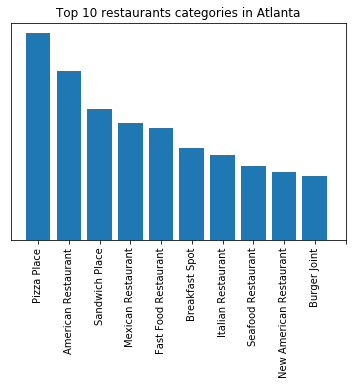

In [47]:
plt.bar(top10Restaurants.index, top10Restaurants['Venue Category'])
y_pos = np.arange(11)

plt.xticks(y_pos, top10Restaurants.index, rotation = 'vertical')
plt.yticks([])
plt.title("Top 10 restaurants categories in Atlanta")
plt.show()


## Discussion and Conclusion <a name="conclusion"></a>

As we had guessed initially, our analysis has shown that the diversity of culture in the Atlanta metro area is very well reflected in the wide variety of restaurant choices available in the city.  Pizza places seem to be the top category of restaurants followed by American and Mexican restaurants. Although, there are some pockets of areas in the downtown/midtown area that might benefit from additional Indian restaurants, most of them are well served. As the city expands, there are several neighborhoods outside the metro area that have other well established cuisines, but are lacking Indian restaurants. Stake holders looking to establish one, could very well use this analysis to pick up an appropriate location. 

Here is a summary of the findings:

### Top 10 neighborhoods to open a new Indian restaurant

* Niskey Lake
* Polar Rock
* Regency Trace
* Beecher Hills
* Cascade Heights
* Center Hill
* Audubon Forest
* Audubon Forest West
* Norcross
* Lawrenceville

### Top 10 neighborhoods with already well established Indian restaurants

* Oakcliff
* Five Points
* Margaret Mitchell
* Atlantic Station
* Fairlie-Poplar
* Thomasville Heights
* Peachtree Center
* Johns Creek
* Edgewood
* Scottdale

## Top 10 restaurant categories

* Pizza Place
* American Restaurant	
* Sandwich Place	
* Mexican Restaurant	
* Fast Food Restaurant	
* Breakfast Spot	
* Italian Restaurant	
* Seafood Restaurant	
* New American Restaurant	
* Burger Joint	

Also, this analysis has been done specific to Indian cuisine, the data that has been captured and the analysis that has been performed can easily be leveraged to any other cuisine categories as well.
